---
## Gemini Version

## Residency Obligation Calculation Logic - Technical Documentation

**1. Introduction**

This document outlines the logic used to calculate residency obligations for Canadian Permanent Residents (PRs) and Citizenship eligibility. The calculations are based on a user-provided travel history and a chosen reference date.

**2. Input Data: `travel_log.csv`**

The program reads travel history from a CSV file named `travel_log.csv`. This file must contain the following columns:

*   `start_date`: Date of departure from Canada (YYYY-MM-DD format).
*   `end_date`: Date of return to Canada (YYYY-MM-DD format).
*   `trip_name`:  A descriptive name for the trip (string), can indicate 'work' or 'personal'.

**3. Core Calculation Steps**

*   **Reference Date:** The user provides a reference date (or defaults to today). All calculations are performed relative to this date.
*   **5-Year Lookback Window:** A 5-year lookback window is defined, starting 5 years prior to the reference date and ending on the reference date. This window is used to assess residency obligations. Leap years are accounted for in the window calculation.
*   **Days Outside Canada within Lookback Window:**
    *   The program iterates through each trip in the `travel_log.csv`.
    *   For each trip, it determines the period that falls within the 5-year lookback window.
    *   The duration of each trip segment within the lookback window is calculated **inclusively** (both start and end dates are counted). These durations are summed up to get the total days spent outside Canada within the 5-year window.
*   **Days Inside Canada within Lookback Window:** The total number of days in the 5-year lookback window is calculated. Days spent inside Canada are then derived by subtracting the 'Days Outside Canada within Lookback Window' from the 'Total days in the lookback window'.
*   **Residency Obligation Shortfalls:**
    *   **PR Obligation Shortfall:** Calculated as `max(0, 730 - Days Inside Canada)`.  PRs need to be physically present in Canada for at least 730 days within the last 5 years to maintain PR status.
    *   **Citizenship Eligibility Shortfall:** Calculated as `max(0, 1095 - Days Inside Canada)`.  Applicants for Canadian citizenship generally need to be physically present in Canada for at least 1095 days within the last 5 years prior to application.
*   **Projected Eligibility Dates:**
    *   To estimate projected dates for meeting PR obligation and Citizenship eligibility, the program calculates the 'shortfall' days.
    *   It then projects forward from the 'Reference Date', assuming continuous physical presence in Canada from the reference date onwards. The projected date is simply the reference date plus the number of 'shortfall' days.

**4. Key Assumptions**

*   **5-Year Lookback:** The calculations are based on a 5-year lookback period, consistent with common residency requirements.
*   **PR and Citizenship Day Requirements:**  The program uses 730 days for PR obligation and 1095 days for Citizenship eligibility as target thresholds. These are general guidelines and specific requirements may vary based on individual circumstances and changes in legislation.
*   **Continuous Stay for Projections:** Projected PR obligation met and Citizenship eligibility dates are estimated assuming continuous physical presence in Canada from the 'Reference Date'. This is a simplification, and actual eligibility dates may vary based on future travel patterns.

**5. Output**

The program provides:

*   Summary of calculated days inside and outside Canada within the 5-year lookback window.
*   Shortfalls from PR Residency Obligation and Citizenship Eligibility.
*   Projected dates for meeting PR obligation and Citizenship eligibility (with the above assumptions).
*   A Gantt chart visualizing the travel history within the 5-year lookback window, color-coded by trip type ('work' or other).

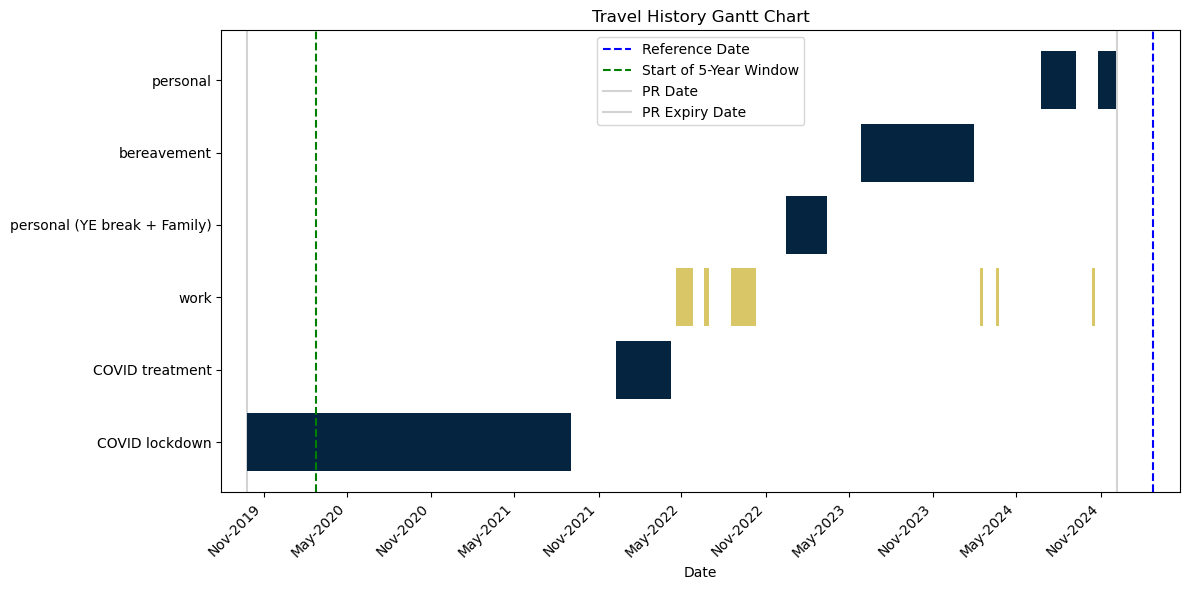

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import calendar  # Import the calendar module

class ResidencyTracker:
    def __init__(self, travel_log_file):
        self.travel_log_file = travel_log_file
        self.today = datetime.today().date()
        self.data = self.load_data()
        self.pr_date = datetime(2019, 9, 26).date()  # Date of PR status
        self.chart_start_date = datetime(2019, 8, 1).date() # Fixed chart start date - August 2019
        self.pr_expiry_date = datetime(2024, 12, 7).date() # Fixed PR expiry date - December 7, 2024

    def load_data(self):
        """Load travel log from a CSV file."""
        df = pd.read_csv(self.travel_log_file, parse_dates=['start_date', 'end_date'])
        return df.sort_values(by='start_date')

    def calculate_residency(self, reference_date=None):
        """Calculate residency days within the last 5 years from a given reference date."""
        if reference_date is None:
            reference_date = self.today
        else:
            reference_date = datetime.strptime(reference_date, '%Y-%m-%d').date()

        start_window = reference_date - timedelta(days=5*365.25) # Leap year correction
        total_days = (reference_date - start_window).days
        out_of_country_days = 0

        for _, row in self.data.iterrows():
            if row['end_date'].date() < start_window:
                continue  # Ignore trips before the window

            trip_start = max(row['start_date'].date(), start_window)
            trip_end = min(row['end_date'].date(), reference_date)

            out_of_country_days += (trip_end - trip_start).days + 1 # Corrected line: Added + 1

        in_country_days = total_days - out_of_country_days
        shortfall_pr = max(0, 730 - in_country_days)
        shortfall_citizen = max(0, 1095 - in_country_days)

        pr_eligibility_date = reference_date + timedelta(days=shortfall_pr)
        citizen_eligibility_date = reference_date + timedelta(days=shortfall_citizen)

        results = { # Returning a dictionary for easier comparison
            "reference_date": reference_date,
            "lookback_window_start": start_window,
            "out_of_country_days": out_of_country_days,
            "in_country_days": in_country_days,
            "shortfall_pr": shortfall_pr,
            "shortfall_citizen": shortfall_citizen,
            "pr_eligibility_date": pr_eligibility_date,
            "citizen_eligibility_date": citizen_eligibility_date
        }
        return results

    def plot_gantt_chart(self, reference_date=None):
        """Generate a Gantt chart of travel history with color coding for work/personal trips."""
        if reference_date is None:
            reference_date = self.today
        else:
            reference_date = datetime.strptime(reference_date, '%Y-%m-%d').date()

        start_window = reference_date - timedelta(days=5*365.25) #Leap year correction

        fig, ax = plt.subplots(figsize=(12, 6))

        # Set the x-axis start date - ensure it's at least chart_start_date
        start_date_xaxis = min(start_window, self.chart_start_date) # Use min to take the earlier date

        # Extend x-axis end date by 2 months
        end_date_xaxis = reference_date + timedelta(days=2 * 30) # Roughly 2 months extension

        ax.set_xlim(start_date_xaxis, end_date_xaxis) # Set x limits to extended range

        for i, row in enumerate(self.data.itertuples()):
            color = '#D9C666' if 'work' in row.trip_name.lower() else '#042440'
            # Only plot trips that start after the chart start date
            if row.start_date.date() >= self.chart_start_date:
                ax.barh(row.trip_name, (row.end_date - row.start_date).days + 1, left=row.start_date, color=color) # Corrected line in plot as well

        ax.axvline(reference_date, color='blue', linestyle='--', label='Reference Date')
        ax.axvline(start_window, color='green', linestyle='--', label='Start of 5-Year Window')
        ax.axvline(self.pr_date, color='lightgrey', linestyle='-', label='PR Date', zorder=0) # Ensure PR Date line is behind bars
        ax.axvline(self.pr_expiry_date, color='lightgrey', linestyle='-', label='PR Expiry Date', zorder=0) # Added PR Expiry Date line


        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
        ax.set_xlabel('Date')
        ax.set_title('Travel History Gantt Chart')
        ax.legend()
        plt.xticks(rotation=45, ha='right') # Rotate and align text for better readability
        plt.tight_layout() # Improve layout
        plt.show()


# Example usage
tracker = ResidencyTracker('travel_log.csv')
tracker.calculate_residency()
tracker.plot_gantt_chart()